### Compare Clustering of the Embeddings
Run experiments to compare clustering algorithms that best cluster the image embeddings.

In [1]:
import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))

sys.path.insert(0, project_root)

In [2]:
import numpy as np
import hdbscan
import umap
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sturdy_barnacle.db_utils import DatabaseManager
import matplotlib.pyplot as plt

class ImageClusterComparison:
    """Compares PCA, UMAP, and t-SNE for improving HDBSCAN clustering."""

    def __init__(self, db: DatabaseManager, min_cluster_size=10, min_samples=2):
        self.db = db
        self.min_cluster_size = min_cluster_size
        self.min_samples = min_samples

    def load_embeddings(self):
        """Fetch image embeddings from the database and normalize them."""
        images = self.db.query_all_images()
        embeddings = np.array([img.embedding for img in images])
        
        # Normalize embeddings
        scaler = StandardScaler()
        scaled_embeddings = scaler.fit_transform(embeddings)

        return scaled_embeddings, images

    def apply_pca(self, embeddings, n_components=50):
        """Reduces dimensions using PCA."""
        pca = PCA(n_components=n_components)
        reduced_embeddings = pca.fit_transform(embeddings)
        explained_variance = sum(pca.explained_variance_ratio_)
        return reduced_embeddings, explained_variance

    def apply_umap(self, embeddings, n_components=50):
        """Reduces dimensions using UMAP."""
        reducer = umap.UMAP(n_components=n_components, random_state=42)
        reduced_embeddings = reducer.fit_transform(embeddings)
        return reduced_embeddings

    def apply_tsne(self, embeddings, n_components=2, perplexity=30.0):
        """Reduces dimensions using t-SNE."""
        reducer = TSNE(n_components=n_components, perplexity=perplexity, random_state=42)
        reduced_embeddings = reducer.fit_transform(embeddings)
        return reduced_embeddings

    def cluster_hdbscan(self, embeddings):
        """Clusters using HDBSCAN."""
        clusterer = hdbscan.HDBSCAN(min_cluster_size=self.min_cluster_size, 
                                    min_samples=self.min_samples, 
                                    metric="euclidean")
        labels = clusterer.fit_predict(embeddings)
        return labels

    def run_comparison(self):
        """Runs PCA, UMAP, and t-SNE comparison and evaluates clustering performance."""
        embeddings, images = self.load_embeddings()

        # Apply PCA
        pca_embeddings, explained_variance = self.apply_pca(embeddings)
        pca_labels = self.cluster_hdbscan(pca_embeddings)
        num_pca_clusters = len(set(pca_labels) - {-1})

        # Apply UMAP
        umap_embeddings = self.apply_umap(embeddings)
        umap_labels = self.cluster_hdbscan(umap_embeddings)
        num_umap_clusters = len(set(umap_labels) - {-1})

        # Apply t-SNE
        tsne_embeddings = self.apply_tsne(embeddings)
        tsne_labels = self.cluster_hdbscan(tsne_embeddings)
        num_tsne_clusters = len(set(tsne_labels) - {-1})

        # Show results
        print(f"PCA Clusters: {num_pca_clusters}, Explained Variance: {explained_variance:.2f}")
        print(f"UMAP Clusters: {num_umap_clusters}")
        print(f"t-SNE Clusters: {num_tsne_clusters}")

        # Plot PCA, UMAP, and t-SNE clusters
        self.visualize_clusters(pca_embeddings, pca_labels, "PCA + HDBSCAN Clusters")
        self.visualize_clusters(umap_embeddings, umap_labels, "UMAP + HDBSCAN Clusters")
        self.visualize_clusters(tsne_embeddings, tsne_labels, "t-SNE + HDBSCAN Clusters")

    def visualize_clusters(self, embeddings, labels, title):
        """Visualizes clusters in 2D."""
        plt.figure(figsize=(8, 6))
        plt.scatter(embeddings[:, 0], embeddings[:, 1], c=labels, cmap="Spectral", s=5)
        plt.colorbar()
        plt.title(title)
        plt.show()


All table names are validated and safe.


/Users/mamduhzabidi/Documents/GitHub/sturdy-barnacle/myenv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/mamduhzabidi/Documents/GitHub/sturdy-barnacle/myenv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/mamduhzabidi/Documents/GitHub/sturdy-barnacle/myenv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/mamduhzabidi/Documents/GitHub/sturdy-barnacle/myenv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/mamduhzabidi/Documents/GitHub/sturdy-barnacle/myen

PCA Clusters: 66, Explained Variance: 0.58
UMAP Clusters: 122
t-SNE Clusters: 109


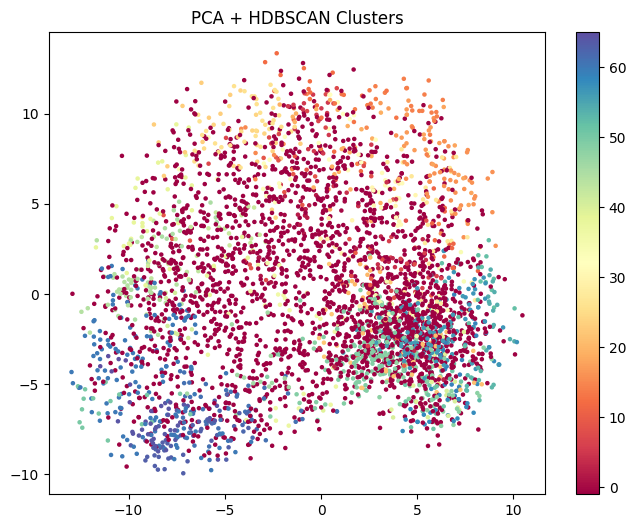

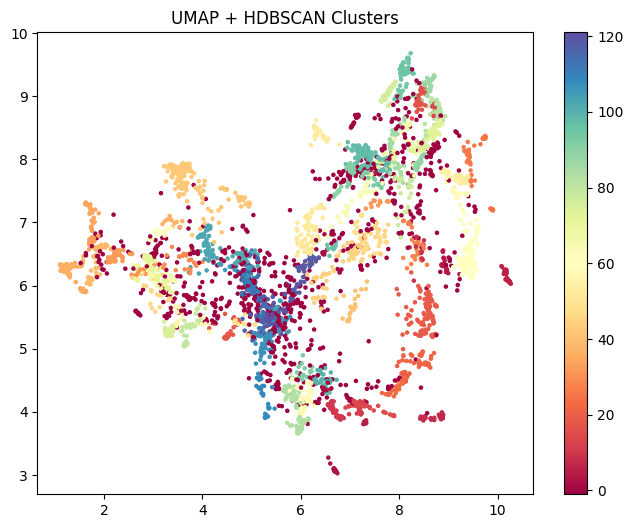

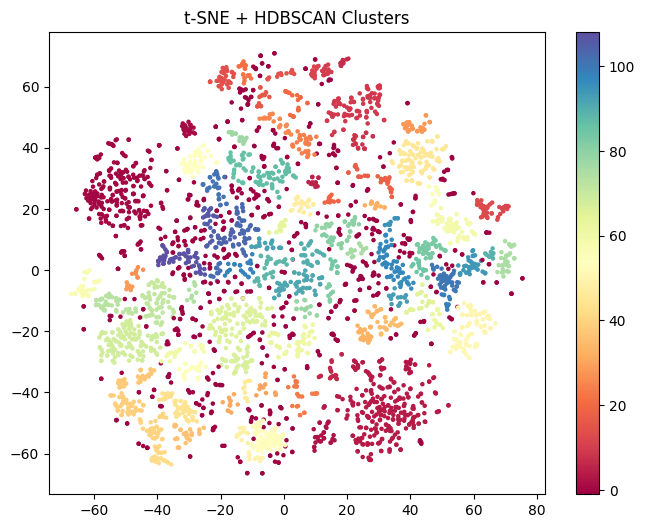

In [3]:
db = DatabaseManager()
cluster_comparator = ImageClusterComparison(db)

cluster_comparator.run_comparison()